# 자료의 종류_결측값, 이상치 처리

# 데이터분석 순서(KDD 분석 방법론)
* 데이터 세트 선택: CSV, EXCEL, DB 에서 데이터를 읽어옴
* 데이터 전처리: 데이터타입, 결측값, 이상치탐지, 데이터분포분석, 상관관계
* 데이터 변환(특성추출): 원본 데이터에서 새로운 데이터 생성, 삭제, 스케일링, 구간화
* 데이터 마이닝(모델만들기, 분석): 분석에 적합한 알고리즘 선택, 모델 생성, 튜닝
* 결과 평가: 테스트 데이터를 이용해서 데이터 마이닝으로 만든 모델의 성능 평가

# 데이터 전처리
* 데이터 타입 변환
* 결측치 탐지 및 보간
* 이상치 탐지 및 처리
* 데이터 특성 파악(치우침, 분포 특성)
* 변수들 간의 상관관계 분석

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1. 데이터 세트 선택 및 로딩

In [75]:
data = pd.read_csv("./data/Titanic_train.csv")
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [76]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


In [77]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [78]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# 4. 결측값 찾고, 비율 보고, 대치 / 삭제하기
* 결측값 비율 계산: isna().sum() / len(데이터프레임) * 100
* 결측값 비율이 5% 미만: 행, 열을 제거, 분석에 크게 영향을 미치지 않음
* 결측값 비율이 5% ~ 30%: 결측값을 대체(Imputation)
  * 수치형 데이터(숫자형, 나이, 가격): 평균(mean), 중앙값(median), 최빈값(mode)으로 대체
  * 범주형 데이터(문자형/(숫자형), 선실등급, 탑승지: 최빈값(mode)으로 대체
* 결측값 비율이 30% ~ 50%: 컬럼의 중요도에 따라서 결측값을 대체 혹은 삭제
  * KNN(K-Nearest Neighbor, 최근접이웃) imputer, 회귀분석을 통해 결측값 대체
* 결측값 비율이 50% 이상: 해당 컬럼 삭제

In [79]:
# 결측값 비율 구하기
data.isna().sum() / len(data) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

## 결측 데이터의 종류
* MCAR(완전 무작위 결측): 다른 변수와 무관하게 생긴 결측(랜덤, 이유 없음)
  * 설문 조사중 일부 응답자가 무작위로 답변을 건너뜀
* MAR(무작위 결측): 다른 변수와는 관련 있지만 본인과는 무관
  * 나이가 많은 사람들이 소득란에 응답을 하지 않는 경우(나이와 관련)
  * 직업에 따라서 학력란에 응답하지 않는 경우(가정환경, 소득)
* NMAR(비무작위 결측): 변수 자기 자신과 직접 관련이 있는 경우
  * 소득이 낮은 사람이 자신의 소득을 숨기는 경우(소득과 결측이 직접 관련)
  * 체중이 많이 나가는 경우 자신의 체중을 숨기는 경우
  * 만족도가 낮은 고객이 만족도 조사에 응하지 않는 경우

## 결측치 처리방법
### 1) 단순대치법(simple imputaion)
#### (1) 완전분석: 결측값이 있는 모든 행을 삭제하고 완전한 자료만으로 분석(잘 안씀)
* 결측값을 삭제해도 모델을 만들기에 충분히 많은 데이터가 있는 경우
* 결측값을 삭제한 후에 데이터에 편향이 없다는 전제가 있을 때
* dropna(): 결측값이 있는 모든 행 삭제

In [80]:
data.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [81]:
data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

#### (2) 평균 대치법: 결측치가 있는 컬럼에서 데이터의 평균을 구한 후 결측값을 대치
* 평균을 이용하기 때문에 간편
* 데이터에 이상치가 있을 경우 평균을 이용할 수 없다.
* 데이터에 이상치가 있는 경우 중앙값이나 최빈값을 이용해야 한다.

In [82]:
a = pd.Series([24, 5, 10, 34, 20, 18, 28, 25, 23])
b = pd.Series([24, 5, 10, 34, 20, 18, 28, 2000, 23])

In [83]:
print(f"a의 평균 {a.mean()}")
print(f"b의 평균 {b.mean()}")

a의 평균 20.77777777777778
b의 평균 240.22222222222223


In [84]:
print(sorted(a))
print(sorted(b))

[5, 10, 18, 20, 23, 24, 25, 28, 34]
[5, 10, 18, 20, 23, 24, 28, 34, 2000]


In [85]:
print(f"a의 중앙값 {a.median()}")
print(f"b의 중앙값 {b.median()}")

a의 중앙값 23.0
b의 중앙값 23.0


* Age 컬럼의 결측값을 평균 대치법으로 대치

In [86]:
age_na_idx = data[data['Age'].isna()].index

In [87]:
age_na = data.loc[age_na_idx].copy()
age_na

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [88]:
age_na['Age'] = age_na['Age'].fillna(data['Age'].mean())

In [89]:
age_na

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,29.699118,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,29.699118,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,29.699118,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,29.699118,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,29.699118,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,29.699118,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,29.699118,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,29.699118,0,0,349217,7.8958,NaN,S


중앙값 median으로 대치

In [90]:
age_na2 = data.loc[age_na_idx].copy()
age_na2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [91]:
age_na2['Age'] = age_na2['Age'].fillna(data['Age'].median())
age_na2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,28.0,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,28.0,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,28.0,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,28.0,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,28.0,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,28.0,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,28.0,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,28.0,0,0,349217,7.8958,NaN,S


In [92]:
embarked_na = data[data['Embarked'].isna()].copy()
embarked_na

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [93]:
data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [94]:
data['Embarked'].mode()[0]

'S'

In [95]:
embarked_na['Embarked'] = embarked_na['Embarked'].fillna(data['Embarked'].mode()[0])
embarked_na

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


# Scikit-learn의 simple imputer를 이용한 대치

In [96]:
# !pip install scikit-learn

In [97]:
from sklearn.impute import SimpleImputer

In [98]:
imp_mean = SimpleImputer(strategy='mean')

In [99]:
data2 = data.copy()
data2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [100]:
data2[['Age']].shape

(891, 1)

In [101]:
data2['Age'] = imp_mean.fit_transform(data2[['Age']])
data2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [110]:
data3 = data.copy()

In [112]:
data3.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [117]:
data3['Age'].median()

np.float64(28.0)

In [116]:
imp_median = SimpleImputer(strategy='median')
data3['Age'] = imp_median.fit_transform(data3[['Age']]).ravel()
data3.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [118]:
data4 = data.copy()

In [122]:
imp_mode = SimpleImputer(strategy='most_frequent')
data4['Embarked']= imp_mode.fit_transform(data4[['Embarked']]).flatten()
data4.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     891 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


# 결측값 비율이 30% ~ 50% 일 때, KNN 최근접이웃법

In [135]:
data5 = data.copy()

In [136]:
data5.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# KNN = K - Nearest Neighbor(최근접 이웃)

In [137]:
from sklearn.impute import KNNImputer

In [138]:
knn_imp = KNNImputer(n_neighbors=20)
data5['Age'] = knn_imp.fit_transform(data5[['Age']])[:, 0]
data5.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,370376,7.75,NaN,Q


# 이상치(outlier) 탐지 및 처리

# 이상값(outlier) 탐지
* 이상값: 데이터 집합에서 다른 값들과 뚜렷하게 다른 값
* 통계적으로 평균을 왜곡시킴, 모델의 결과를 왜곡시킬 수 있음
* 전체 데이터 분포에서 **정상 범위**에 속하지 않는 데이터 

## 이상값 탐지 방법 3가지
* Z-score가 -3 ~ 3 범위를 넘어가는 경우: 극단적인 이상값을 탐지
* 평균을 기준으로 평균에서 ±(3*표준편차)를 넘는 경우: 표준편차가 큰 경우에는 잘 못잡음
* IQR(사분위수) 기준으로 계산한 상위 하위 이상값을 넘는 경우: 정규·비정규분포에서 모두 강함

## 1) Z-score로 이상값 탐지하기
* z-score: (값 - 평균) / 표준편차
* 평균: .mean()
* 표준편차: .std()

* Fare 컬럼의 Z-score 구하기

In [139]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# 평균과 표준편차를 구해서 z-score 계산하기
# zscore = (값 - 평균) / 표준편차

In [140]:
fare_mean = data['Fare'].mean()
fare_mean

np.float64(32.204207968574636)

In [143]:
fare_std = data['Fare'].std()
fare_std

np.float64(49.6934285971809)

In [145]:
data['z_score'] = (data['Fare'] - fare_mean) / fare_std 

In [146]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,z_score
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-0.502163
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.786404
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-0.488580
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.420494
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-0.486064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,-0.386454
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,-0.044356
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,-0.176164
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,-0.044356


In [148]:
data[(data['z_score'] < -3) | (data['z_score'] > 3)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,z_score
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,4.644393
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,4.644393
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,4.332899
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,9.661740
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,4.332899
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,4.631815
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,4.644393
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,3.608038
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C,3.930516
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,4.644393


* scipy.stats.zscore 이용해 zscore 계산하기

In [149]:
from scipy.stats import zscore

In [151]:
data['z_score2'] = zscore(data['Fare'])
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,z_score,z_score2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-0.502163,-0.502445
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.786404,0.786845
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-0.488580,-0.488854
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.420494,0.420730
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-0.486064,-0.486337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,-0.386454,-0.386671
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,-0.044356,-0.044381
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,-0.176164,-0.176263
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,-0.044356,-0.044381


In [164]:
# z-score로 구한 이상치 기준
data.loc[(data['z_score'] < -3) | (data['z_score'] > 3), 'Fare'].min()

np.float64(211.3375)

## 2) 평균과 표준편차를 이용해 이상값 찾기 ESD(Extreme Studentized Deiation)
* 평균±(3표준편차) $ ({\mu\pm 3 \sigma}) $

In [157]:
data['Fare'].mean() + data['Fare'].std() + data['Fare'].std() + data['Fare'].std()

np.float64(181.28449376011736)

In [153]:
data['Fare'].std()

np.float64(49.6934285971809)

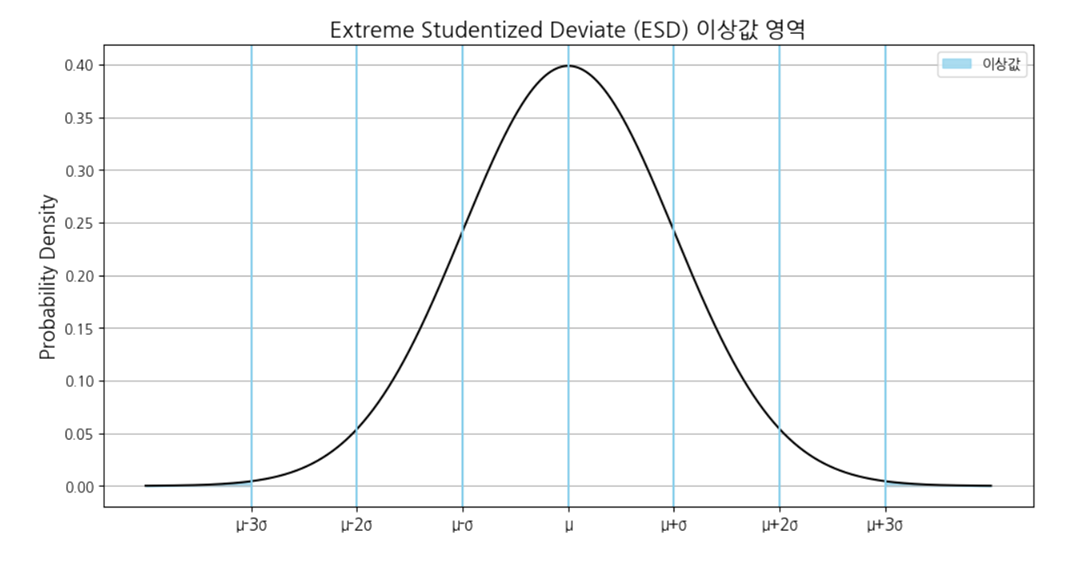

In [158]:
fare_mean

np.float64(32.204207968574636)

In [159]:
data['Fare'].std()

np.float64(49.6934285971809)

In [160]:
lower_bound = fare_mean - (3 * data['Fare'].std())
upper_bound = fare_mean + (3 * data['Fare'].std())
print("lower_bound: ", lower_bound, "upper_bound: ", upper_bound)

lower_bound:  -116.87607782296804 upper_bound:  181.2844937601173


## 3) IQR(사분위수)를 이용한 이상값 탐지
### (1) IQR 이란?
* IQR은 데이터의 중간 50% 구간의 길이를 의미
* IQR은 0, 25, 50, 75, 100
* IQR공식: Q3(75%) - Q1(25%)

### (2) IQR로 이상값을 찾는 이유?
* 평균과 표준편차는 극단적인 값에 민감
* IQR은 중간값 기반이라 극단값(outlier)에 영향을 덜 받음
* 정규분포가 아닌 데이터에서도 이상치를 잘 찾을 수 있음

### (3) IQR 기반 이상값 판정 기준
* 하한값: Q1(25%) - (1.5 * (Q3(75%)-Q1(25%))
* 상한값: Q3(75%) + (1.5 * (Q3(75%)-Q1(25%))


In [169]:
fare_desc = data['Fare'].describe()
fare_desc

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [168]:
iqr_lower_bound = 7.910400 - (1.5 * (31.000000 - 7.910400))
iqr_upper_bound = 31.000000 + (1.5 * (31.000000 - 7.910400))
print("iqr_lower_bound: ", iqr_lower_bound,  "iqr_upper_bound: ", iqr_upper_bound)

iqr_lower_bound:  -26.724 iqr_upper_bound:  65.6344


In [171]:
fare_desc['75%'] + (1.5 * (fare_desc['75%'] - fare_desc['25%']))

np.float64(65.6344)

In [173]:
data_desc = data.describe()
data_desc

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,z_score,z_score2
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,-1.196200e-17,3.987333e-18
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.000000e+00,1.000562e+00
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,-6.480577e-01,-6.484217e-01
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,-4.888737e-01,-4.891482e-01
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,-3.571902e-01,-3.573909e-01
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,-2.423274e-02,-2.424635e-02
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,9.661740e+00,9.667167e+00


In [176]:
data_desc.loc['75%'] + (1.5 * (data_desc.loc['75%'] - data_desc.loc['25%']))

PassengerId    1336.000000
Survived          2.500000
Pclass            4.500000
Age              64.812500
SibSp             2.500000
Parch             0.000000
Fare             65.634400
z_score           0.672729
z_score2          0.673106
dtype: float64

# 상자수염그림(boxplot)을 이용해서 컬럼의 이상치 여부 판단하기

<Axes: >

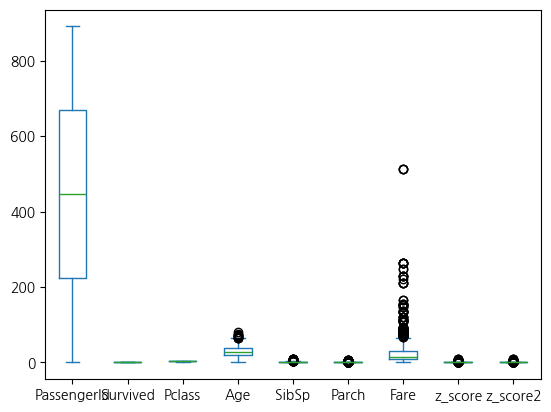

In [177]:
data.plot(kind='box')

In [180]:
data.select_dtypes(exclude="str")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,z_score,z_score2
0,1,0,3,22.0,1,0,7.2500,-0.502163,-0.502445
1,2,1,1,38.0,1,0,71.2833,0.786404,0.786845
2,3,1,3,26.0,0,0,7.9250,-0.488580,-0.488854
3,4,1,1,35.0,1,0,53.1000,0.420494,0.420730
4,5,0,3,35.0,0,0,8.0500,-0.486064,-0.486337
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,-0.386454,-0.386671
887,888,1,1,19.0,0,0,30.0000,-0.044356,-0.044381
888,889,0,3,NaN,1,2,23.4500,-0.176164,-0.176263
889,890,1,1,26.0,0,0,30.0000,-0.044356,-0.044381


In [181]:
data.select_dtypes(include="str")

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


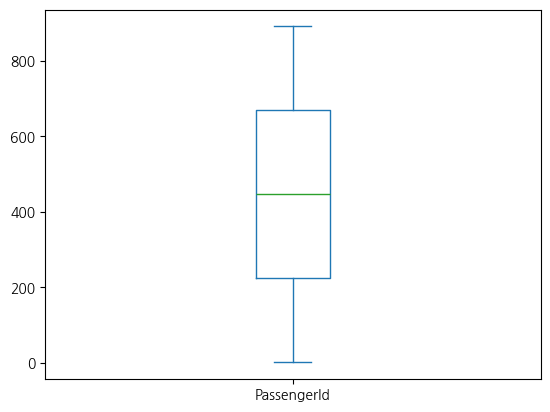

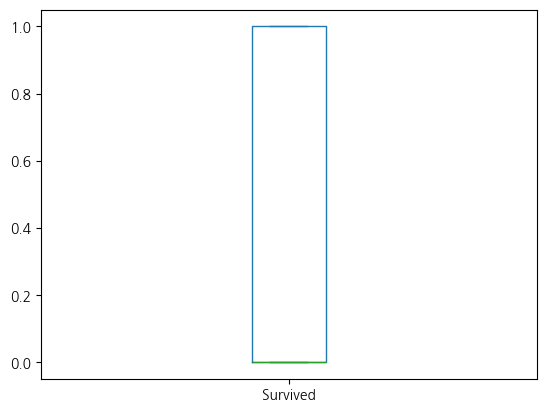

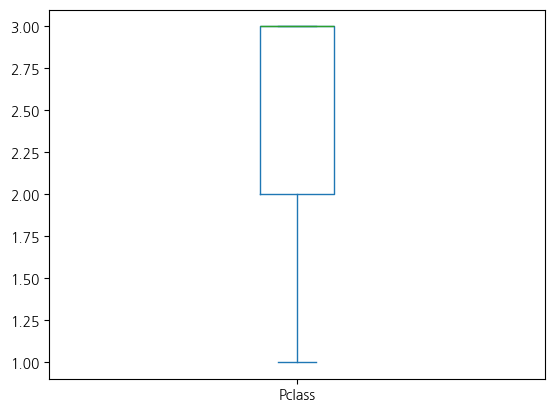

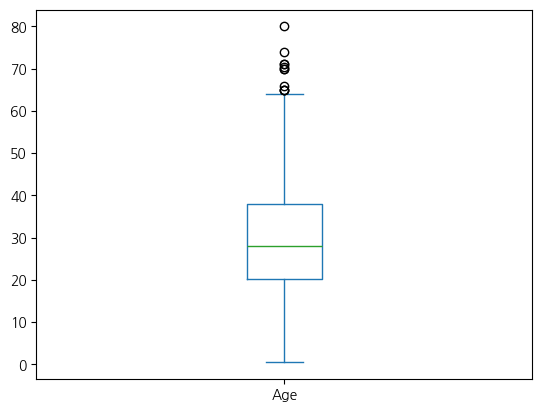

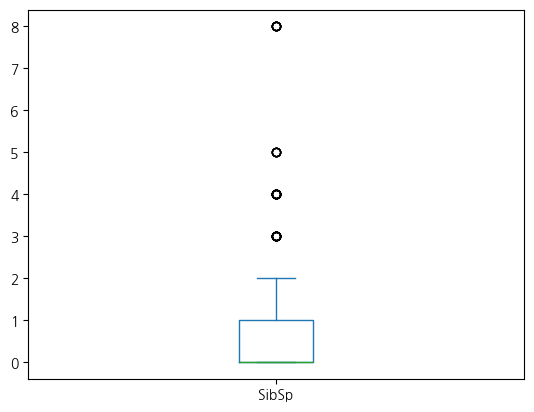

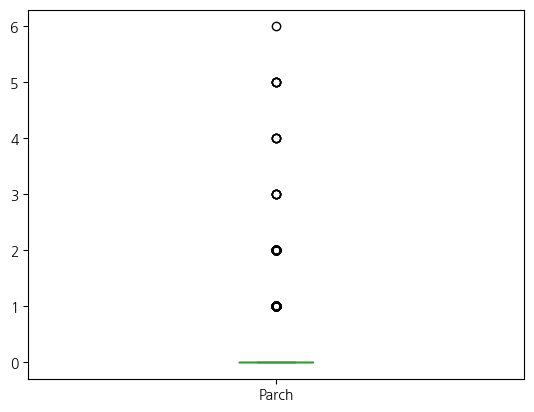

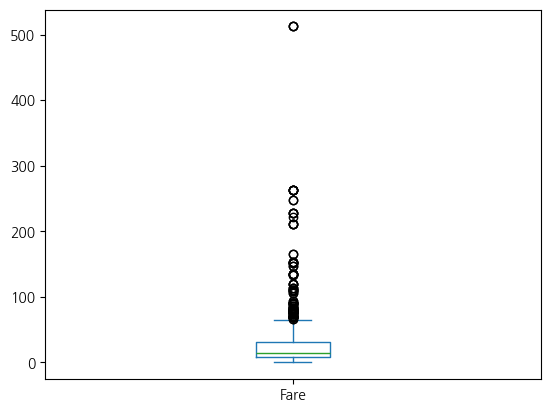

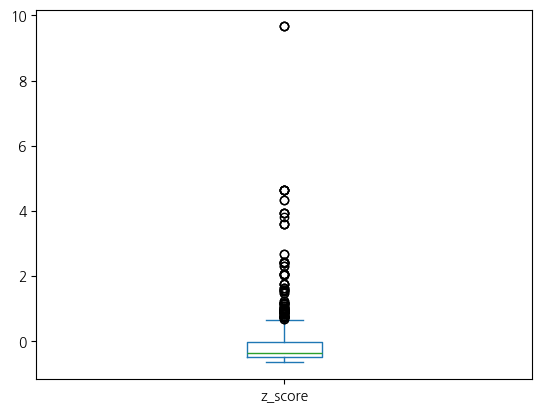

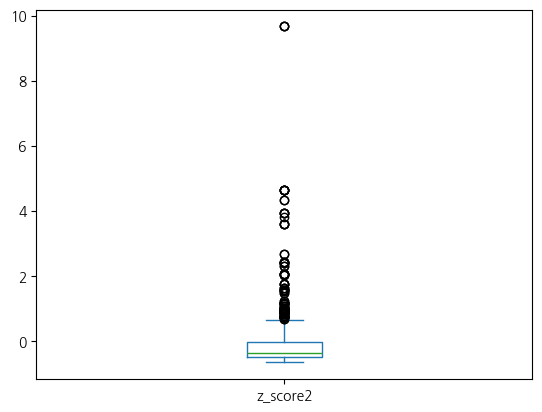

In [182]:
for col in data.select_dtypes(exclude="str").columns:
    data[col].plot(kind='box')
    plt.show()

# 이상치 처리 방법 6가지
| 방법 | 설명 | 주의사항 |
|:----|:----|:----|
| 1. 삭제 (제거) | 이상치인 행(row) 삭제 | 데이터 수가 많을 때만 추천 |
| 2. 대체 (수정) | 평균, 중앙값 등으로 이상치 값을 대체 | 대체 값이 데이터의 특성을 망가뜨릴 수 있음 |
| 3. 변환 | 로그(log), 루트(sqrt) 변환해서 이상치 영향을 줄이기 | 주로 오른쪽으로 긴 분포(Skewed Data) |
| 4. 구간 압축 (Winsorization) | 상/하위 극단값을 일정 값으로 '컷' | 통계 왜곡 최소화할 때 사용 |
| 5. 모델링 시 Robust 방법 사용 | 이상치에 강한 모델 사용 (예: RobustScaler, RANSAC) | 이상치를 제거하지 않고 대응 |
| 6. 별도 분석 | 이상치만 따로 분석해서 인사이트 얻기 | 이상치가 중요한 의미를 가질 때 |